## Melhor até agora -> Comparar esse aqui com o dataset doidão

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.cm as cm
import random
import glob
import os
from skimage.segmentation import chan_vese
import numpy as np
import PIL 
from PIL import Image 
from tensorboard.plugins.hparams import api as hp
import pandas as pd
from shutil import copy
import cv2

# Display
# from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# My functions
import my_functions as mf

# tf explain
from tf_explain.callbacks.grad_cam import GradCAMCallback

In [3]:
random_seed = 42

In [4]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
   'datasets/ct_scan_3/train',
   labels='inferred',
   label_mode='int',
   class_names=None,
   color_mode='rgb',
   batch_size=batch_size,
   image_size=image_size,
   shuffle=True, 
   seed=random_seed, 
   interpolation='bilinear',
   follow_links=False,
   crop_to_aspect_ratio=False)

Found 11851 files belonging to 2 classes.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
   'datasets/ct_scan_3/val',
   labels='inferred',
   label_mode='int',
   class_names=None,
   color_mode='rgb',
   batch_size=batch_size,
   image_size=image_size,
   shuffle=True, 
   seed=random_seed,
   interpolation='bilinear',
   follow_links=False,
   crop_to_aspect_ratio=False)

Found 2632 files belonging to 2 classes.


In [6]:
inputs = keras.Input(shape=(img_height, img_width, 3))

data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal"), 
      layers.RandomRotation(0.1)
    ]
)
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1/127.5, offset=-1)
x = scale_layer(x)
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
base_model = keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3),
    input_tensor=x
)
last_layer_base_model = mf.find_last_layer(base_model)

x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_base_model.output)

x = keras.layers.Dense(units=128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=32, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

base_model.trainable = False # Freeze base model

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 89, 89, 32)   864         rescaling[0][0]                  
______________________________________________________________________________________________

In [7]:
gcam_image_path = "datasets\\ct_scan_3\\val\\COVID-positive\\P021_106.png"

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

run_logdir = mf.get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

data = (mf.get_img_array(gcam_image_path, image_size), None)
grd_cam_callback = GradCAMCallback(
   validation_data=data,
   class_index=0,
   output_dir=run_logdir,
)

epochs = 100
base_model.trainable = False
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[
      tensorboard_cb, 
      early_stopping_cb, 
      grd_cam_callback])

Epoch 1/100
371/371 [==============================] - 72s 163ms/step - loss: 0.5987 - accuracy: 0.6804 - val_loss: 0.4083 - val_accuracy: 0.8340
Epoch 2/100
371/371 [==============================] - 54s 146ms/step - loss: 0.4685 - accuracy: 0.7675 - val_loss: 0.4536 - val_accuracy: 0.7872
Epoch 3/100
371/371 [==============================] - 52s 141ms/step - loss: 0.4529 - accuracy: 0.7917 - val_loss: 0.3999 - val_accuracy: 0.8275
Epoch 4/100
371/371 [==============================] - 52s 141ms/step - loss: 0.4185 - accuracy: 0.8220 - val_loss: 0.3661 - val_accuracy: 0.8484
Epoch 5/100
371/371 [==============================] - 53s 143ms/step - loss: 0.4031 - accuracy: 0.8211 - val_loss: 0.3698 - val_accuracy: 0.8511
Epoch 6/100
371/371 [==============================] - 53s 144ms/step - loss: 0.3954 - accuracy: 0.8286 - val_loss: 0.3605 - val_accuracy: 0.8552
Epoch 7/100
371/371 [==============================] - 54s 146ms/step - loss: 0.3847 - accuracy: 0.8363 - val_loss: 0.3888 -

[[0.78882045]]


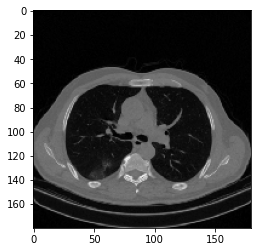

In [9]:
img_path = "datasets\\ct_scan_3\\val\\COVID-positive\\P004_130.png"
img_array = mf.get_img_array(img_path, size=image_size)
preds = model.predict(img_array)
print(preds)
plt.imshow(img_array[0, :, :, :].astype(int))

[[0.17669827]]


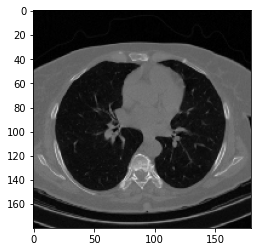

In [10]:
img_path = "datasets\\ct_scan_3\\val\\COVID-negative\\N025_65.png"
img_array = mf.get_img_array(img_path, size=image_size)
preds = model.predict(img_array)
print(preds)
plt.imshow(img_array[0, :, :, :].astype(int))

In [11]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True)

run_logdir = mf.get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

data = (mf.get_img_array(gcam_image_path, image_size), None)
grd_cam_callback = GradCAMCallback(
   validation_data=data,
   class_index=0,
   output_dir=run_logdir,
)

epochs = 100
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
     callbacks=[
      tensorboard_cb, 
      early_stopping_cb, 
      grd_cam_callback])

run_modeldir = mf.get_model_dir()
model.save(run_modeldir)

Epoch 1/100
371/371 [==============================] - 194s 472ms/step - loss: 0.4439 - accuracy: 0.8122 - val_loss: 0.3588 - val_accuracy: 0.8381
Epoch 2/100
371/371 [==============================] - 164s 443ms/step - loss: 0.3021 - accuracy: 0.8772 - val_loss: 0.2918 - val_accuracy: 0.8853
Epoch 3/100
371/371 [==============================] - 163s 439ms/step - loss: 0.2592 - accuracy: 0.8978 - val_loss: 0.2668 - val_accuracy: 0.9054
Epoch 4/100
371/371 [==============================] - 158s 427ms/step - loss: 0.2290 - accuracy: 0.9121 - val_loss: 0.2760 - val_accuracy: 0.9020
Epoch 5/100
371/371 [==============================] - 161s 434ms/step - loss: 0.2005 - accuracy: 0.9195 - val_loss: 0.2529 - val_accuracy: 0.9069
Epoch 6/100
371/371 [==============================] - 160s 431ms/step - loss: 0.1891 - accuracy: 0.9246 - val_loss: 0.2861 - val_accuracy: 0.8940
Epoch 7/100
371/371 [==============================] - 153s 413ms/step - loss: 0.1681 - accuracy: 0.9311 - val_loss: 0

In [6]:
model = keras.models.load_model("my_models\\run_2021_11_07-19_12_26")

In [8]:
model.evaluate(val_ds)

83/83 [==============================] - 12s 138ms/step - loss: 0.2486 - accuracy: 0.9160


[0.24858605861663818, 0.9160334467887878]

[[0.99402]]


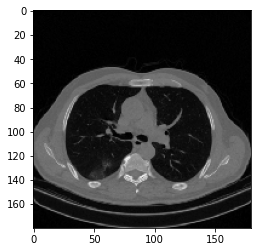

In [7]:
img_path = "datasets\\ct_scan_3\\val\\COVID-positive\\P004_130.png"
img_array = mf.get_img_array(img_path, size=image_size)
preds = model.predict(img_array)
print(preds)
plt.imshow(img_array[0, :, :, :].astype(int))

[[0.00141283]]


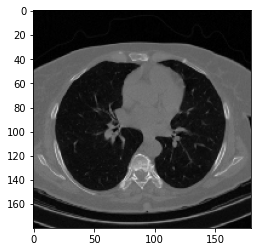

In [8]:
img_path = "datasets\\ct_scan_3\\val\\COVID-negative\\N025_65.png"
img_array = mf.get_img_array(img_path, size=image_size)
preds = model.predict(img_array)
print(preds)
plt.imshow(img_array[0, :, :, :].astype(int))